# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Read in data

In [2]:
games = pd.read_csv('../data/cleaned_games.csv')
games.head(3)

,name,mc_slug,metascore,user_score,date_released,summary,genres,rating,api_id,description
0,Mass Effect 2,mass-effect-2,94.0,8.9,"Jan 26, 2010",The Mass Effect trilogy is a science fiction a...,"{'Action RPG', 'Role-Playing'}",M,4806.0,"Mass Effect II is a sequel to Mass Effect one,..."
1,Starcraft II: Wings of Liberty,starcraft-ii-wings-of-liberty,93.0,8.3,"Jul 27, 2010",StarCraft II continues the epic saga of the Pr...,"{'Strategy', 'Command', 'Sci-Fi', 'Real-Time'}",T,38067.0,StarCraft II: Wings of Liberty is a strategy g...
2,World of Warcraft: Cataclysm,world-of-warcraft-cataclysm,90.0,5.7,"Dec 7, 2010","In Cataclysm, players witness the face of Azer...","{'Massively Multiplayer', 'Massively Multiplay...",T,39685.0,World of Warcraft: Cataclysm is a RPG massivel...


# Exploratory Data Analysis

In [3]:
# Number of missing values in each column
# Since almost half of the ratings are missing due them being optional for PC games, 
# I will not be using them in my recommender system

games.isnull().sum()

name                0
mc_slug             0
metascore           7
user_score         63
date_released       0
summary            36
genres              2
rating           1244
api_id             45
description        58
dtype: int64

## Missing genres

The links to theses games on Metacritic returned a 404 error, so neither the summaries nor genres were scraped. The genres will be filled in with data from the API.

In [4]:
# Missing genres
games[games['genres'].isnull()]

,name,mc_slug,metascore,user_score,date_released,summary,genres,rating,api_id,description
989,Memento Mori 2,memento-mori-2,65.0,7.5,"May 13, 2014",NaN,NaN,NaN,19515.0,An award winning adventure crime thriller with...
1655,NightCry,nightcry,46.0,3.0,"Mar 28, 2016",NaN,NaN,NaN,17134.0,"A calming cruise, an unexpected horror. Welcom..."


In [5]:
# Function for genres from RAWG API

def get_genres(api_id):
    url = f"https://rawg-video-games-database.p.rapidapi.com/games/{int(api_id)}"
    headers = {
        'x-rapidapi-host': "rawg-video-games-database.p.rapidapi.com",
        'x-rapidapi-key': # your api key here
    }

    res = requests.request('GET', url, headers=headers)
    genres = [genre['name'] for genre in res.json()['genres']]
    
    return str(genres)

In [6]:
# Memento Mori 2
games.loc[989, 'genres'] = get_genres(games['api_id'][989])

# NightCry
games.loc[1655, 'genres'] = get_genres(games['api_id'][1655])

## Most common genres

In [7]:
# List of all the genres in the data
genres_list = []

for genre in games['genres']:
    # Since the genres are strings, need to remove the brackets and quotes before splitting
    # it on the comma separating each genre
    genres_list += re.sub('[^-,\w\s]', '', genre).split(', ')

# Unique genres
genres = set(genres_list)

In [8]:
# Number of games of each genre
genre_freq = {genre: genres_list.count(genre) for genre in genres}

In [9]:
# Sort genres in descending order
pd.Series(genre_freq).sort_values(ascending=False)

General                 1040
Action                   785
Strategy                 446
Adventure                424
Action Adventure         409
                        ... 
Boxing  Martial Arts       1
Hunting                    1
Rail                       1
Stacking                   1
Olympic Sports             1
Length: 133, dtype: int64

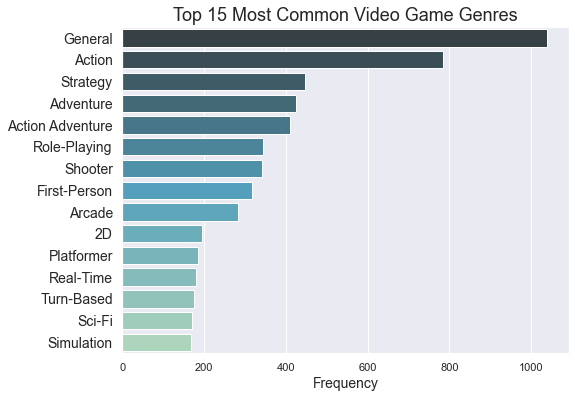

In [10]:
# Bar plot of the top 15 most common video game genres
# Metacritic has a tendency to combine two genres into one (ex. Action Adventure) but also include Action
# and Adventure as well making it a bit redundant. 

plt.figure(figsize=(8, 6))
sns.set()

sns.barplot(x = pd.Series(genre_freq).sort_values(ascending=False)[:15],
            y = pd.Series(genre_freq).sort_values(ascending=False).index[:15],
            palette = "GnBu_d")

plt.title('Top 15 Most Common Video Game Genres', fontsize=18)
plt.xlabel('Frequency', fontsize=14)
plt.yticks(fontsize=14);

## Relationship between metascore and user score

Although there seems to be a linear relationship between the metascore and user score, you can see that the points are a bit spread out. Highly rated games tended to have a high user score too, however, there are also quite a few games that had a high metascore but very low user score and vice versa.

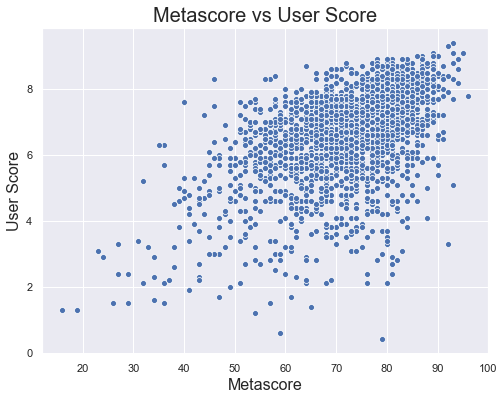

In [11]:
# Scatter plot depicting the relationship between the metascore and user score

plt.figure(figsize=(8, 6))

sns.scatterplot(games['metascore'], games['user_score'])

plt.xlabel('Metascore', fontsize=16)
plt.ylabel('User Score', fontsize=16)
plt.title('Metascore vs User Score', fontsize=20);

## Missing scores

Due to the somewhat linear relationship between metascore and user score, missing metascores will be imputed with the user score and vice versa.

In [12]:
# Fill missing metascores with user score
games['metascore'].fillna(games['user_score'], inplace=True)

# Fill missing user scores with metascore
games['user_score'].fillna(games['metascore'], inplace=True)

## Release dates by month

In [13]:
# Convert dates to datetime object
games['date_released'] = pd.to_datetime(games['date_released'])

In [14]:
# Number of games released between 2010-2020 by month
games['date_released'].dt.month.value_counts().sort_index()

1     179
2     213
3     245
4     245
5     250
6     171
7     178
8     228
9     235
10    257
11    210
12    125
Name: date_released, dtype: int64

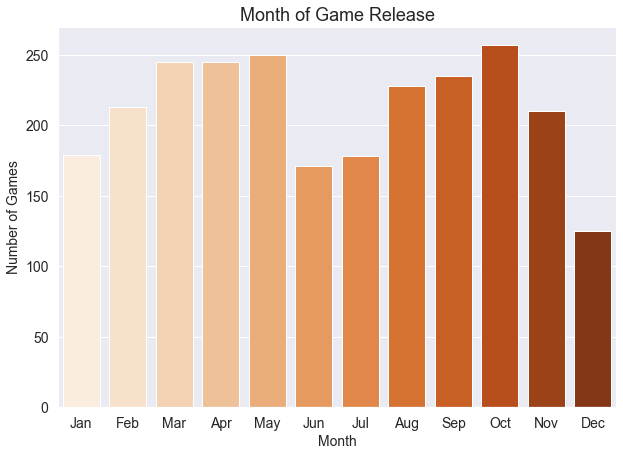

In [15]:
# Plot games released by month
plt.figure(figsize=(10, 7))
sns.set()

sns.barplot(x = games['date_released'].dt.month.value_counts().sort_index().index,
            y = games['date_released'].dt.month.value_counts().sort_index().values,
            palette = "Oranges")

plt.title('Month of Game Release', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)

months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
plt.xticks(range(0,12), months, fontsize=14)
plt.yticks(fontsize=14);

# Choose summary/description to use

Pick the longer text between summary and description to use in the model.

In [16]:
# Function for picking the longer summaries/descriptions

def pick_summary_descrip(row):
    # If there is no summary, return description
    if pd.isnull(row['summary']):
        return row['description']
    
    # If there is no description, return summary
    elif pd.isnull(row['description']):
        return row['summary']
    
    # If lengths are equal, return summary
    elif len(row['summary'].split()) == len(row['description'].split()):
        return row['summary']
    
    # If summary if longer, return summary
    elif len(row['summary'].split()) > len(row['description'].split()):
        return row['summary']
    
    # If description is longer, return description
    elif len(row['summary'].split()) < len(row['description'].split()):
        return row['description']

## Clean summaries

Some of the summaries start with the word "summary", so before I run the function for choosing the longer text, I need to clean up the summaries by removing "summary" from the text.

In [17]:
# Remove "summary" from summaries
games['summary'] = games['summary'].map(lambda summary: summary.replace('Summary: ', ''),
                         na_action='ignore')

## Apply function

In [18]:
games['model_description'] = games.apply(pick_summary_descrip, axis=1)

In [19]:
games.head()

,name,mc_slug,metascore,user_score,date_released,summary,genres,rating,api_id,description,model_description
0,Mass Effect 2,mass-effect-2,94.0,8.9,2010-01-26,The Mass Effect trilogy is a science fiction a...,"{'Action RPG', 'Role-Playing'}",M,4806.0,"Mass Effect II is a sequel to Mass Effect one,...","Mass Effect II is a sequel to Mass Effect one,..."
1,Starcraft II: Wings of Liberty,starcraft-ii-wings-of-liberty,93.0,8.3,2010-07-27,StarCraft II continues the epic saga of the Pr...,"{'Strategy', 'Command', 'Sci-Fi', 'Real-Time'}",T,38067.0,StarCraft II: Wings of Liberty is a strategy g...,StarCraft II continues the epic saga of the Pr...
2,World of Warcraft: Cataclysm,world-of-warcraft-cataclysm,90.0,5.7,2010-12-07,"In Cataclysm, players witness the face of Azer...","{'Massively Multiplayer', 'Massively Multiplay...",T,39685.0,World of Warcraft: Cataclysm is a RPG massivel...,"In Cataclysm, players witness the face of Azer..."
3,Sid Meier's Civilization V,sid-meiers-civilization-v,90.0,8.0,2010-09-21,"With over nine million units sold worldwide, a...","{'Strategy', 'Turn-Based', '4X', 'Historic'}",E10+,13633.0,Real-time strategy genre has always been about...,Real-time strategy genre has always been about...
4,BioShock 2,bioshock-2,88.0,8.0,2010-02-09,Set approximately 10 years after the events of...,"{'First-Person', 'Sci-Fi', 'Shooter', 'Action'...",M,4427.0,The second game returns us to the city of Rapt...,The second game returns us to the city of Rapt...


## Replace non-descript descriptions

Some of the descriptions from RAWG contain no real details about the game except an overall user rating for the game, the date the game was released, and the platforms on which you can play these games on. These descriptions typically contain the words RAWG or rawger. They will be replaced with the summary from Metacritic.

In [20]:
# Get the indices of all the descriptions that contain RAWG or rawger
rawg = games[games['model_description'].str.contains('RAWG') | 
             games['model_description'].str.contains('rawger')].index

In [21]:
# Replace them with the summary if summary is not missing
for i in rawg:
    if pd.notna(games['summary'][i]):
        games.loc[i, 'model_description'] = games['summary'][i]
    else:
        pass

# Clean text for modeling

## Genres

Tokenize and return only the unique genres.

In [22]:
# Function for cleaning the genres for modeling

def clean_genres(genre):
    # Remove quotations and brackets
    genres_only = re.sub('[^-\w\s]', '', genre)
    
    # Lowercase and tokenize
    lower = genres_only.lower().split(' ')
    
    # Join the unique words back together as a string
    return (' '.join(set(lower)))

In [23]:
# Clean genres
games['clean_genres'] = games['genres'].map(clean_genres)
games.head(2)

,name,mc_slug,metascore,user_score,date_released,summary,genres,rating,api_id,description,model_description,clean_genres
0,Mass Effect 2,mass-effect-2,94.0,8.9,2010-01-26,The Mass Effect trilogy is a science fiction a...,"{'Action RPG', 'Role-Playing'}",M,4806.0,"Mass Effect II is a sequel to Mass Effect one,...","Mass Effect II is a sequel to Mass Effect one,...",action role-playing rpg
1,Starcraft II: Wings of Liberty,starcraft-ii-wings-of-liberty,93.0,8.3,2010-07-27,StarCraft II continues the epic saga of the Pr...,"{'Strategy', 'Command', 'Sci-Fi', 'Real-Time'}",T,38067.0,StarCraft II: Wings of Liberty is a strategy g...,StarCraft II continues the epic saga of the Pr...,sci-fi strategy command real-time


## Description

For the descriptions, I will be removing any numbers and special characters, tokenizing the leftover text, and removing all stopwords before joining the text back together into a string.

In [24]:
# Function for cleaning description for modeling

def clean_description(text):
    # Remove all non-letters
    letters_only = re.sub('[^a-zA-Z]', ' ', text)
    
    # Lowercase and tokenize
    words = letters_only.lower().split()
    
    # Remove stopwords and lemmatize remaining words
    stops = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    meaningful_words = [lemmatizer.lemmatize(w) for w in words if w not in stops]
    
    # Return the words joined back together as a string
    return (' '.join(meaningful_words))

In [25]:
# Clean description
games['clean_descrip'] = games['model_description'].map(clean_description)
games.head(2)

,name,mc_slug,metascore,user_score,date_released,summary,genres,rating,api_id,description,model_description,clean_genres,clean_descrip
0,Mass Effect 2,mass-effect-2,94.0,8.9,2010-01-26,The Mass Effect trilogy is a science fiction a...,"{'Action RPG', 'Role-Playing'}",M,4806.0,"Mass Effect II is a sequel to Mass Effect one,...","Mass Effect II is a sequel to Mass Effect one,...",action role-playing rpg,mass effect ii sequel mass effect one followin...
1,Starcraft II: Wings of Liberty,starcraft-ii-wings-of-liberty,93.0,8.3,2010-07-27,StarCraft II continues the epic saga of the Pr...,"{'Strategy', 'Command', 'Sci-Fi', 'Real-Time'}",T,38067.0,StarCraft II: Wings of Liberty is a strategy g...,StarCraft II continues the epic saga of the Pr...,sci-fi strategy command real-time,starcraft ii continues epic saga protoss terra...


# Save as csv file

In [26]:
games.to_csv('../data/ready_to_model.csv', index=False)